In [1]:
import os
import cv2
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import pickle
import math
from scipy.misc import toimage
random.seed()

In [2]:
def jj(*args):
    return os.path.join(*args)

FACES = jj('data','faces')
OBJECTS = jj('data','objects')

FACES_GREY = jj('data','faces_grey')
OBJECTS_GREY = jj('data','objects_grey')

FACES_GREY_EQ = jj('data','faces_grey_eq')
OBJECTS_GREY_EQ = jj('data','objects_grey_eq')

FACES_EDGES = jj('data','faces_edges')
OBJECTS_EDGES = jj('data','objects_edges')

IMG_SIZE = 100
NUMBER_OF_FACES = 2000
NUMBER_OF_OBJECTS = 2000

In [3]:
def jj(*args):
    return os.path.join(*args)


def open_image(full_image_name):
    return cv2.imread(full_image_name, cv2.IMREAD_GRAYSCALE)  # grey scale


def resize(img, n):
    return cv2.resize(img, (n, n))


def resize_image_to_nxn_square(img, n):
    longer_side = max(img.shape)
    horizontal_padding = int((longer_side - img.shape[0]) / 2)
    vertical_padding = int((longer_side - img.shape[1]) / 2)

    new_image = cv2.copyMakeBorder(img,
                                   horizontal_padding,
                                   horizontal_padding,
                                   vertical_padding,
                                   vertical_padding,
                                   cv2.BORDER_CONSTANT)
    resized_img = resize(new_image, n)
    return resized_img


def reshape_to_on_dim_vector(array):
    return np.reshape(np.reshape(array, (IMG_SIZE * IMG_SIZE)), (1, -1))

In [4]:
class Canny(object):
    def __init__(self, img, minVal, maxVal):
        self.minVal = minVal
        self.maxVal = maxVal
        self.gaussian_filter = np.asarray([[1, 4, 7, 4, 1],
                                           [4, 16, 26, 16, 4],
                                           [7, 26, 41, 26, 7],
                                           [4, 16, 26, 16, 4],
                                           [1, 4, 7, 4, 1]]) / 273

        self.sobel_Gx_filter = np.asarray([[-1, 0, 1],
                                           [-2, 0, 2],
                                           [-1, 0, 1]])

        self.sobel_Gy_filter = np.asarray([[-1, -2, -1],
                                           [0, 0, 0],
                                           [1, 2, 1]])

        self.array = np.asarray(img)
        self.height, self.width = self.array.shape[0], self.array.shape[1]

        self.array_after_gaussian_filtering = np.zeros(self.array.shape)
        self.array_after_Gx = np.zeros(self.array.shape)
        self.array_after_Gy = np.zeros(self.array.shape)
        self.array_G = np.zeros(self.array.shape)
        self.array_theta = np.zeros(self.array.shape)
        self.array_nmax_suppress = np.zeros(self.array.shape)
        self.array_after_thresholding = np.zeros(self.array.shape)

        self.run()

    def run(self):
        self.set_gaussian_filtered_array()
        self.set_array_after_Gx()
        self.set_array_after_Gy()
        self.set_array_after_G()
        self.set_array_after_theta()
        self.set_array_after_suppression()
        self.set_array_after_thresholding()

    def get_features(self):
        plt.imshow(self.array_after_thresholding)
        plt.show()
        return self.array_after_thresholding

    def set_gaussian_filtered_array(self):
        zero_padded_array = np.pad(self.array, 2, mode='constant')
        self.convolve(zero_padded_array, self.gaussian_filter, self.array_after_gaussian_filtering)

    def set_array_after_Gx(self):
        zero_padded_array = np.pad(self.array_after_gaussian_filtering, 1, mode='constant')
        self.convolve(zero_padded_array, self.sobel_Gx_filter, self.array_after_Gx)

    def set_array_after_Gy(self):
        zero_padded_array = np.pad(self.array_after_gaussian_filtering, 1, mode='constant')
        self.convolve(zero_padded_array, self.sobel_Gy_filter, self.array_after_Gy)

    def set_array_after_G(self):
        self.array_G = np.sqrt(np.square(self.array_after_Gx) + np.square(self.array_after_Gy))

    def set_array_after_theta(self):
        self.array_theta = np.arctan2(self.array_after_Gy, self.array_after_Gx) * 180 / math.pi

    def set_array_after_suppression(self):
        for row in range(self.height):
            for col in range(self.width):
                if self.width - 1 > col > 0 and self.height - 1 > row > 0:
                    # 0 degrees
                    if (22.5 > self.array_theta[row][col] >= -22.5) or (self.array_theta[row][col] < -157.5 or self.array_theta[row][col] >= 157.5):
                        if self.array_G[row][col] >= self.array_G[row][col + 1] and self.array_G[row][col] >= self.array_G[row][col - 1]:
                            self.array_nmax_suppress[row][col] = self.array_G[row][col]

                    # 45 degrees
                    if (67.5 > self.array_theta[row][col] >= 22.5) or (-112.5 > self.array_theta[row][col] >= -157.5):
                        if self.array_G[row][col] >= self.array_G[row - 1][col - 1] and self.array_G[row][col] >= self.array_G[row + 1][col + 1]:
                            self.array_nmax_suppress[row][col] = self.array_G[row][col]

                    # 90 degrees
                    if (112.5 > self.array_theta[row][col] >= 67.5) or (-67.5 > self.array_theta[row][col] >= -112.5):
                        if self.array_G[row][col] >= self.array_G[row - 1][col] and self.array_G[row][col] >= self.array_G[row + 1][col]:
                            self.array_nmax_suppress[row][col] = self.array_G[row][col]

                    # 135 degrees
                    if (157.5 > self.array_theta[row][col] >= 112.5) or (-22.5 > self.array_theta[row][col] >= -67.5):
                        if self.array_G[row][col] >= self.array_G[row - 1][col + 1] and self.array_G[row][col] >= self.array_G[row + 1][col - 1]:
                            self.array_nmax_suppress[row][col] = self.array_G[row][col]

    def set_array_after_thresholding(self):
        self._set_strong_edges()
        self._set_weak_edges()

    def _set_strong_edges(self):
        for row in range(self.height):
            for col in range(self.width):
                if self.width - 1 > col > 0 and self.height - 1 > row > 0:
                    if self.array_nmax_suppress[row][col] > self.maxVal:
                        self.array_after_thresholding[row][col] = 1

    def _set_weak_edges(self):
        for row in range(self.height):
            for col in range(self.width):
                if self.width - 1 > col > 0 and self.height - 1 > row > 0:
                    if self.maxVal > self.array_nmax_suppress[row][col] > self.minVal and self._is_connected_with_strong_edge(row, col):
                        self.array_after_thresholding[row][col] = 1

    def _is_connected_with_strong_edge(self, row, col):
        deltas = [(1, 0), (0, 1), (1, 1), (-1, 0), (0, -1), (-1, -1), (-1, 1), (1, -1)]
        for i, j in deltas:
            if self.array_after_thresholding[row + i][col + j] == 1:
                self.array_after_thresholding[row][col] = 1

    def convolve(self, array, filter_array, result_array):
        offset = filter_array.shape[0] // 2
        for row in range(self.height):
            for col in range(self.width):
                if (self.height - 2 * offset >= row >= offset) and (self.width - 2 * offset >= col >= offset):
                    new_value = 0
                    for f_row in range(filter_array.shape[0]):
                        for f_col in range(filter_array.shape[1]):
                            new_value += array[row - offset + f_row][col - offset + f_col] * filter_array[f_row][f_col]
                    result_array[row - offset, col - offset] = new_value

In [5]:
def open_image(full_image_name):
    return cv2.imread(full_image_name, cv2.IMREAD_GRAYSCALE) #grey scale

def resize(img, n):
    return cv2.resize(img, (n, n))

def convert_to_array(img):
    return np.array(img, ndmin=3)

def resize_image_to_nxn_square(img, n):
    longer_side = max(img.shape)
    horizontal_padding = int((longer_side - img.shape[0]) / 2)
    vertical_padding = int((longer_side - img.shape[1]) / 2)
    
    new_image = cv2.copyMakeBorder(img,
                                   horizontal_padding,
                                   horizontal_padding,
                                   vertical_padding,
                                   vertical_padding,
                                   cv2.BORDER_CONSTANT)    
    resized_img = resize(new_image, n)
    return resized_img

def get_dataset():
    faces_list = []
    for img_name in tqdm(os.listdir(FACES)):
        path = jj(FACES, img_name)
        img = open_image(path)
        img = resize_image_to_nxn_square(img, IMG_SIZE)
#         cv2.imwrite(jj(FACES_GREY, img_name), img)
        
#         img = cv2.equalizeHist(img)
#         cv2.imwrite(jj(FACES_GREY_EQ, img_name), img)
        
        img = cv2.Canny(img, 120, 220) # Canny edge detection
#         cv2.imwrite(jj(FACES_EDGES, img_name), img)
        
        array = convert_to_array(img)
        faces_list.append(img)

    objects_list = []    
    for img_name in tqdm(os.listdir(OBJECTS)):
        path = jj(OBJECTS, img_name)
        img = open_image(path)
        img = resize_image_to_nxn_square(img, IMG_SIZE)
#         cv2.imwrite(jj(OBJECTS_GREY, img_name), img)
        
#         img = cv2.equalizeHist(img)
#         cv2.imwrite(jj(OBJECTS_GREY_EQ, img_name), img)
        
        img = cv2.Canny(img, 120, 220) # Canny edge detection
#         cv2.imwrite(jj(OBJECTS_EDGES, img_name), img)
        
        array = convert_to_array(img)
        objects_list.append(img)        

    random.shuffle(faces_list)
    random.shuffle(objects_list)
    
    faces_list = faces_list[:NUMBER_OF_FACES]
    objects_list = objects_list[:NUMBER_OF_OBJECTS]
        
    return faces_list + objects_list


def reshape_to_on_dim_vector(array):
    return np.reshape(array, (array.shape[0], IMG_SIZE * IMG_SIZE))

In [6]:
dataset = get_dataset()
print(len(dataset))
print(dataset[0].shape)

100%|███████████████████████████████████| 16651/16651 [00:30<00:00, 545.95it/s]


4000
(100, 100)


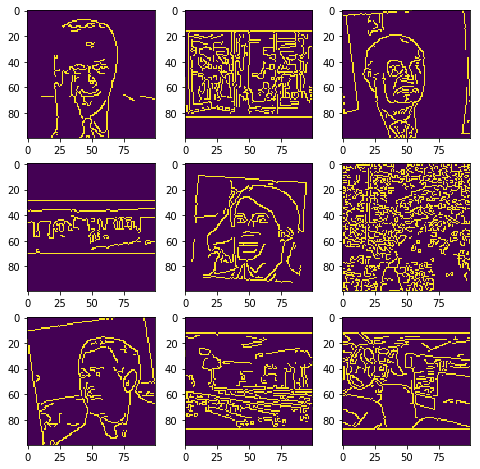

In [7]:
plt.clf()
plt.subplots(figsize=(8, 8))
for i in range(1, 10):
    random_number = random.choice(range(1, len(dataset)))
    plt.subplot(3,3,i)
    plt.imshow(dataset[random_number])
plt.show()

In [8]:
labeled_dataset = [(array, 1 if num < NUMBER_OF_FACES else 0) for num, array in enumerate(dataset)]
random.shuffle(labeled_dataset)

In [9]:
train_validation, test = train_test_split(labeled_dataset, test_size = 0.2, random_state = 0)
train, validation = train_test_split(train_validation, test_size = 0.25, random_state = 0)

x_train = np.asarray([i[0] for i in train])/255
y_train = np.asarray([i[1] for i in train])

x_validation = np.asarray([i[0] for i in validation])/255
y_validation = np.asarray([i[1] for i in validation])

In [10]:
x_train.shape

(2400, 100, 100)

In [11]:
x_train = reshape_to_on_dim_vector(x_train)
x_validation = reshape_to_on_dim_vector(x_validation)


## MODEL EVALUATION

In [12]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

SVM_model = svm.SVC(C=1000000, gamma=0.000001)
SVM_model.fit(x_train, y_train) 

SVC(C=1000000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1e-06, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
pickle.dump(SVM_model, open(jj("data", "svm_model.model"), "wb" ))

In [14]:
# Skuteczność na zbiorze treningowym
y_pred = SVM_model.predict(x_train)
accuracy_score(y_train, y_pred)

1.0

In [17]:
# Skuteczność na zbiorze testowym
y_pred = SVM_model.predict(x_validation)
accuracy_score(y_validation, y_pred)

0.96750000000000003

In [18]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
# Skuteczność na zbiorze treningowym
y_pred = model.predict(x_train)
accuracy_score(y_train, y_pred)

1.0

In [20]:
# Skuteczność na zbiorze testowym
y_pred = model.predict(x_validation)
accuracy_score(y_validation, y_pred)

0.94874999999999998

In [21]:
pickle.dump(model, open(jj("data", "lr_model.model"), "wb" ))